In [0]:
from google.colab import drive
drive.mount("/content/gdrive")

In [0]:
from fastai.vision import *
from fastai import *
import time
import cv2 as cv
import matplotlib.pyplot as plt
import os

In [0]:
#change directory to car_damage for working with this notebook which assumes that you are in the car_damage directory
os.chdir('gdrive/My Drive/car_damage')
!pwd

# SUMMARY OF FIRST EXPERIMENTS WITH DAMAGED CAR CLASSIFICATION


We consider three tagged data sets of damaged cars:

1.   data1a which is about damage vs whole cars
2.   data2a which is about where the damage accured: front, rear, side
3    data3a which is about how severe the damage is:  minor, moderate or severe

Most of the pictures are from the same data set but just tagged specially for each of the tasks.
Actually depending on the tag the pictures are in a different subdirectory.
There are a total of about 1000 pictures roughly. So, not 8000 like in the previous car classification
problem we looked at.

We used resnet 50 and got the following classification results for each of the above
on a separate validation set:



1.   data1a  
                         Correct percentage for damaged cars: 0.97
                         Correct percentage for whole: 0.90
2.   data2a  
                         Correct percentage for side: 0.72
                         Correct percentage for front: 0.90
                        Correct percentage for rear:  0.78

3.   data3a  
                        Correct percentage for minor damages: 0.64
                        Correct percentage for moderate damage:  0.43
                        Correct percentage for severe damage:  0.80


DAMAGED vs WHOLE SEEMS TOO GOOD TO BE TRUE!. Indeed we have a data set 
with only 1000 pictures. Recall that with only 1000 pictures the classification of
type and make is not succesful. But identifying damage should also be somewhat
difficult. Indeed you can have a small scratch or a small bump on different parts of car
or something on window.....of course totaly destroyed car should be easy to recognize 
on other hand.  
And one sees the much lower result for minor moderate and severe. If you consider that
severe is quite easy because then car does not resemble car any more, then minor or moderate
is not far from just chosing at random.
How can it then be so good at deciding damage vs whole? Probably by learning the angle and type
of picture and not be really identifying the damage. The whold picturs are very different: they
are often pictures to sell a car. Nice picture from quite far. The damages like a scratch are close
pictures of the location. SO WE DID A LITTLE EXPERIMENT TO TRICK THE LEARNER.
we took pictures from our own non-damaged car but in angles which are similar to the ones
used to take picutres of locatl damage: close by above the tires and the corner.
RESULT IS THAT WE WERE ABLE TO TRICK THE LEARNER INTO THINKING IT IS DAMAGED
whils it is not. For all but one of these pictures our learner who had been trained on data1a
got it wrong when we gave him our own pictures from non-damaged car but close by picture.
Let us show our own pictures which tricked the learner into believing there is a damage:






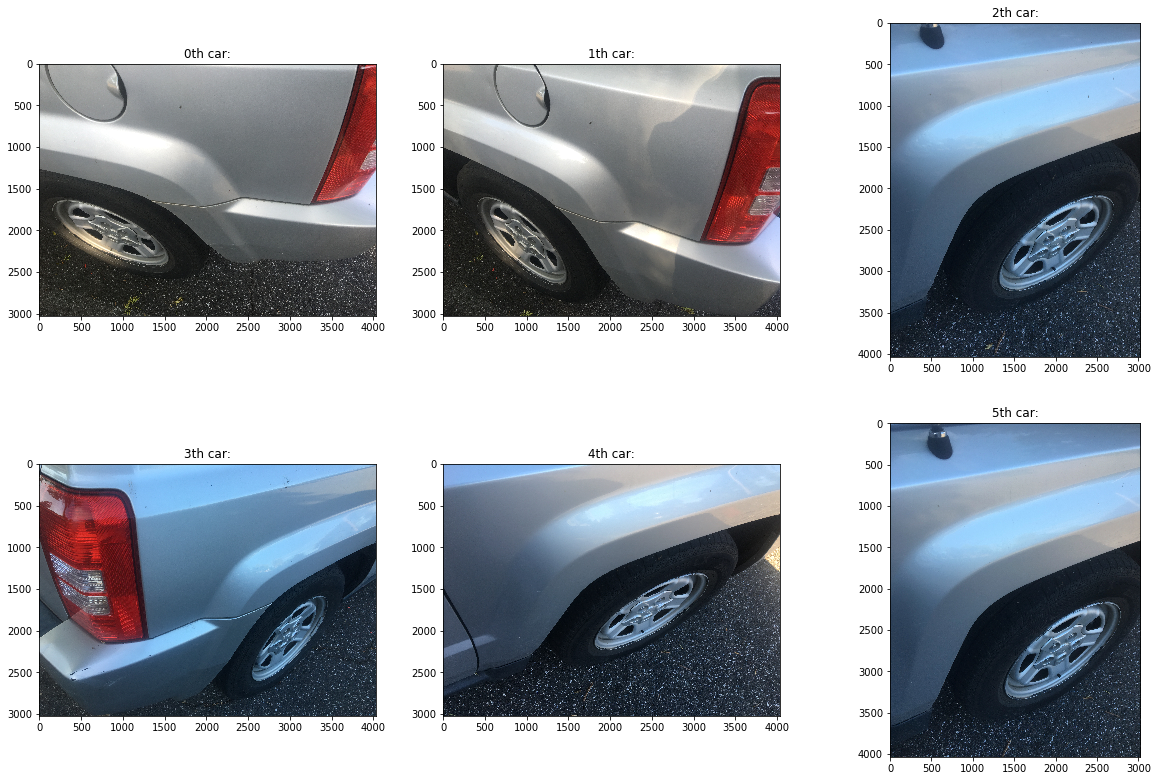

In [6]:
#We make a list with pictures from our own jeep which are contained in data1a/foto
basepath="data1a/foto"
list_foto_matzinger=[os.path.join(basepath,entry) for entry in os.listdir(basepath)]
#then we show these pictures
picture_list=list_foto_matzinger
fig, axs = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(20.5, 13.5)
axs = axs.flatten()
#so the 6 pictures:
for i in range(6):
 axs[i].imshow(open_image(picture_list[i]).data.transpose(2,0).transpose(1,0))
 axs[i].set_title(str(i)+"th car:")


So there are two type of situations: 

A) your training set closely resembles the set of pictures your application
is going to be used with. In that case it may be ok to use all kind of things like angle to classify.

B) you are building a more general application which has to be able to work in very different situations.
In that case it is not ok, to use all kind of info which is particular only to the special data set used for
your training. Because the feature used may be
 correlated to your classification cathegory only in your special data set.

For a theoretical example imagine that  your data set is scratched from web and there the whole cars are usually 
cars for sell
with beautiful pictures and blue sky because the picture to sell the car has to be beautiful.
Then your learner learns that blues sky tends to mean whole car without damage....for classifying pictures
on the web this is valid, but when you have a camera on top of the golden gate bridge and you want to see
which percentage of the cars passing by have damage for some statistical study, the blue sky will not help....


# CLASSIFYING FRONT, REAR, SIDE DAMAGE:


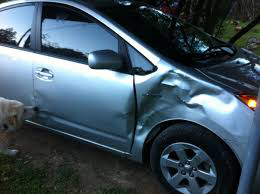

In [0]:

open_image("data2a/training/02-side/0041.JPEG")

In [0]:
#Next we are creating a databunch with the cars picture front, rear back
data=ImageDataBunch.from_folder("data2a",train="training",valid="validation",size=229,bs=20)

data.normalize(imagenet_stats)
learn=cnn_learner(data,models.resnet50,metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 73465968.37it/s]


In [0]:
#next we run the learner:
learn.fit_one_cycle(10)

In [0]:
#learn.save("stage1_resnet50")
learn.load("stage1_resnet50")

In [0]:
learn.unfreeze()

In [0]:
#Next we are making lists with the pictures names and path in the validation directory
#and also list of pictures in training directory
#in order to be able to go through all the misclassified pictures
basepath="data2a/validation/00-front"
list_validation_front=[os.path.join(basepath,entry) for entry in os.listdir(basepath)]
basepath="data2a/validation/01-rear"
list_validation_rear=[os.path.join(basepath,entry) for entry in os.listdir(basepath)]
basepath="data2a/validation/02-side"
list_validation_side=[os.path.join(basepath,entry) for entry in os.listdir(basepath)]
basepath="data2a/training/00-front"
list_training_front=[os.path.join(basepath,entry) for entry in os.listdir(basepath)]
basepath="data2a/training/01-rear"
list_training_rear=[os.path.join(basepath,entry) for entry in os.listdir(basepath)]
basepath="data2a/training/02-side"
list_training_side=[os.path.join(basepath,entry) for entry in os.listdir(basepath)]

print(list_validation_front[:5])

['data2a/validation/00-front/0072.JPEG', 'data2a/validation/00-front/0013.JPEG', 'data2a/validation/00-front/0024.JPEG', 'data2a/validation/00-front/0035.JPEG', 'data2a/validation/00-front/0046.JPEG']


In [0]:
#Next we are going to make different lists of validation pictures for front,rear and side according to if they were classified correctly and those which were classified wrong
#
#FOR SIDE:
picture_list=list_validation_side
list_pred_side=[learn.predict(item=open_image(im_adress))[0] for im_adress in picture_list]
list_pred_side=[str(item) for item in list_pred_side]
#the percentage in validation set that are front and correctly predicted
print("Correct percentage for side:")
print(np.mean(np.array(list_pred_side)=="02-side"))
list_validation_side_error=[a for (a,b) in list(zip(list_validation_side,list_pred_side)) if (b!="02-side")]
list_validation_side_correct=[a for (a,b) in list(zip(list_validation_side,list_pred_side)) if (b=="02-side")]

#FOR FRONT:
picture_list=list_validation_front
list_pred_front=[learn.predict(item=open_image(im_adress))[0] for im_adress in picture_list]
list_pred_front=[str(item) for item in list_pred_front]
#the percentage in validation set that are front and correctly predicted
print("Correct percentage for front:")
print(np.mean(np.array(list_pred_front)=="00-front"))
list_validation_front_error=[a for (a,b) in list(zip(list_validation_front,list_pred_front)) if (b!="00-front")]
list_validation_front_correct=[a for (a,b) in list(zip(list_validation_front,list_pred_front)) if (b=="00-front")]

#FOR REAR:
picture_list=list_validation_rear
list_pred_rear=[learn.predict(item=open_image(im_adress))[0] for im_adress in picture_list]
list_pred_rear=[str(item) for item in list_pred_rear]
#the percentage in validation set that are front and correctly predicted
print("Correct percentage for rear:")
print(np.mean(np.array(list_pred_rear)=="01-rear"))
list_validation_rear_error=[a for (a,b) in list(zip(list_validation_rear,list_pred_rear)) if (b!="01-rear")]
list_validation_rear_correct=[a for (a,b) in list(zip(list_validation_rear,list_pred_rear)) if (b=="01-rear")]


Correct percentage for side:
0.7291666666666666
Correct percentage for front:
0.9041095890410958
Correct percentage for rear:
0.78


IndexError: ignored

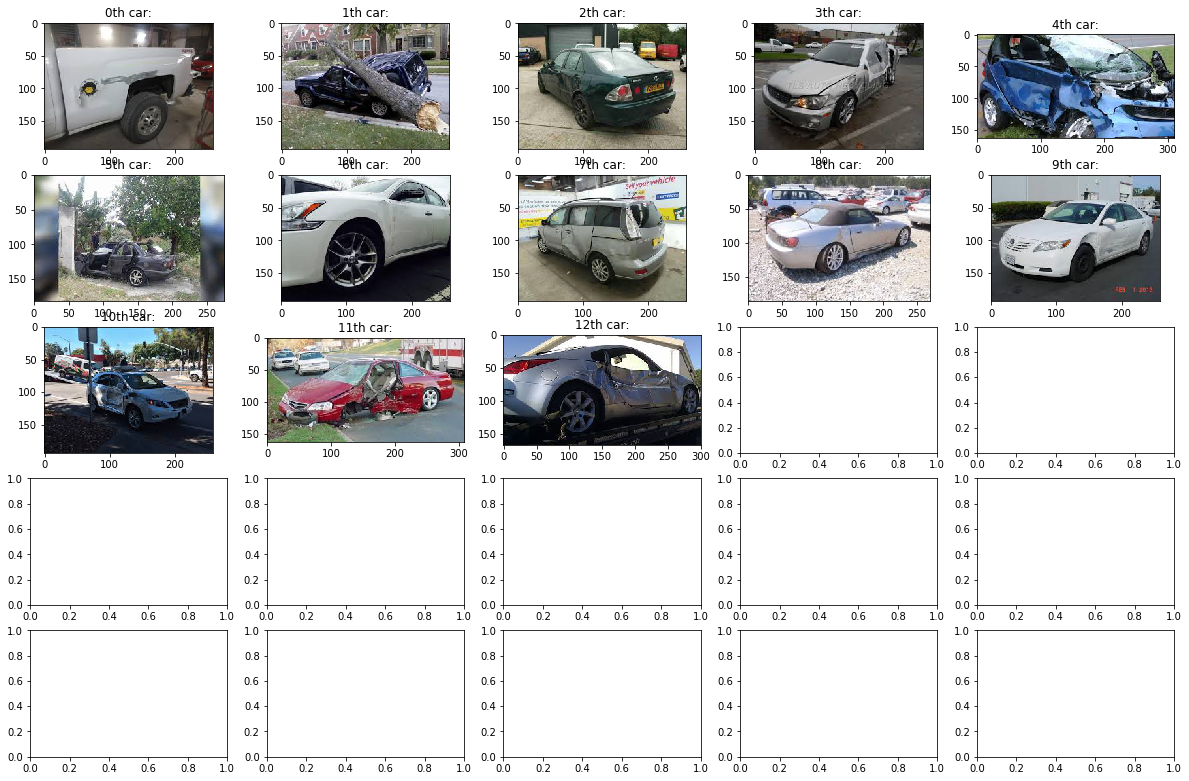

In [0]:
#this cells allows to visualies the cars in the order they are in our training or validation list, 
#One just needs to give in which list of picture one wants by defining picture_list to be the list of picture one
#wants to see
# by displaying matrix of pictures with the number in the list.so as to help create quickly hand-anotations
# much quicker than to display
#you have to define which list of pictures you want to see by putting picture_list equal to the list of adresses of pictures you want to see
picture_list=list_validation_side_error
fig, axs = plt.subplots(nrows=5, ncols=5)
fig.set_size_inches(20.5, 13.5)
axs = axs.flatten()
# Next we define the batch number j. we work with batches of 25 not randomly selected by from our list in
#the order in which they appear in list
j=0



for i in range(25):
 axs[i].imshow(open_image(picture_list[25*j+i]).data.transpose(2,0).transpose(1,0))
 axs[i].set_title(str(25*j+i)+"th car:")

In [0]:
[a for (a,b) in list(zip(list_validation_side,List_pred_side)) if (b!="02-side")]

In [0]:
data.show_batch(rows=2,figsize=(10,8))
print(data.classes)
len(data.classes)

In [0]:
#to check the number of picture we have
data

In [0]:
interp=ClassificationInterpretation.from_learner(learn)

In [0]:
interp.plot_top_losses(25,heatmap=False,figsize=(15,11))

# CLASSIFYING WHOLE VS DAMAGE


In [0]:
#Next we are creating a databunch with the cars damage vs whole
data=ImageDataBunch.from_folder("data1a",train="training",valid="validation",size=229,bs=20)

data.normalize(imagenet_stats)
learn=cnn_learner(data,models.resnet50,metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 46754407.45it/s]


In [0]:
data.show_batch(rows=5,figsize=(15,13))
print(data.classes)
len(data.classes)

In [0]:
#next we run the learner:
learn.fit_one_cycle(10)

In [0]:
learn.save("stage1_resnet50")
learn.load("stage1_resnet50")

In [0]:
learn.unfreeze()

In [0]:
interp=ClassificationInterpretation.from_learner(learn)

In [0]:
interp.plot_top_losses(12,heatmap=False,figsize=(15,11))

In [0]:
#Next we are making lists with the pictures names and path in the validation directory
#and also list of pictures in training directory
#in order to be able to go through all the misclassified pictures
basepath="data1a/validation/00-damage"
list_validation_damage=[os.path.join(basepath,entry) for entry in os.listdir(basepath)]
basepath="data1a/validation/01-whole"
list_validation_whole=[os.path.join(basepath,entry) for entry in os.listdir(basepath)]
basepath="data1a/training/00-damage"
list_training_damage=[os.path.join(basepath,entry) for entry in os.listdir(basepath)]
basepath="data1a/training/01-whole"
list_training_whole=[os.path.join(basepath,entry) for entry in os.listdir(basepath)]

#Next a list with pictures from my jeep which are contained in data1a/foto
basepath="data1a/foto"
list_foto_matzinger=[os.path.join(basepath,entry) for entry in os.listdir(basepath)]

In [0]:
#Next we are going to make different lists of validation pictures for front,rear and side according to if they were classified correctly and those which were classified wrong
#
#FOR DAMAGE:
picture_list=list_validation_damage
list_pred_damage=[learn.predict(item=open_image(im_adress))[0] for im_adress in picture_list]
list_pred_damage=[str(item) for item in list_pred_damage]
#the percentage in validation set that are damaged and correctly predicted
print("Correct percentage for damaged cars:")
print(np.mean(np.array(list_pred_damage)=="00-damage"))
list_validation_damage_error=[a for (a,b) in list(zip(list_validation_damage,list_pred_damage)) if (b!="00-damage")]
list_validation_damage_correct=[a for (a,b) in list(zip(list_validation_damage,list_pred_damage)) if (b=="00-damage")]

#FOR WHOLE:
picture_list=list_validation_whole
list_pred_whole=[learn.predict(item=open_image(im_adress))[0] for im_adress in picture_list]
list_pred_whole=[str(item) for item in list_pred_whole]
#the percentage in validation set that are front and correctly predicted
print("Correct percentage for whole:")
print(np.mean(np.array(list_pred_whole)=="01-whole"))
list_validation_whole_error=[a for (a,b) in list(zip(list_validation_whole,list_pred_whole)) if (b!="01-whole")]
list_validation_whole_correct=[a for (a,b) in list(zip(list_validation_whole,list_pred_whole)) if (b=="01-whole")]

#for my own car pictures in the folder data1/foto

picture_list=list_foto_matzinger
list_pred_matzinger=[learn.predict(item=open_image(im_adress))[0] for im_adress in picture_list]
list_pred_matzinger=[str(item) for item in list_pred_matzinger]
#the percentage in validation set that are front and correctly predicted
print("The predictions for Matzingers jeep are:")
print(list_pred_matzinger)





Correct percentage for damaged cars:
0.9782608695652174
Correct percentage for whole:
0.9043478260869565
The predictions for Matzingers jeep are:
['00-damage', '00-damage', '00-damage', '01-whole', '00-damage', '00-damage']


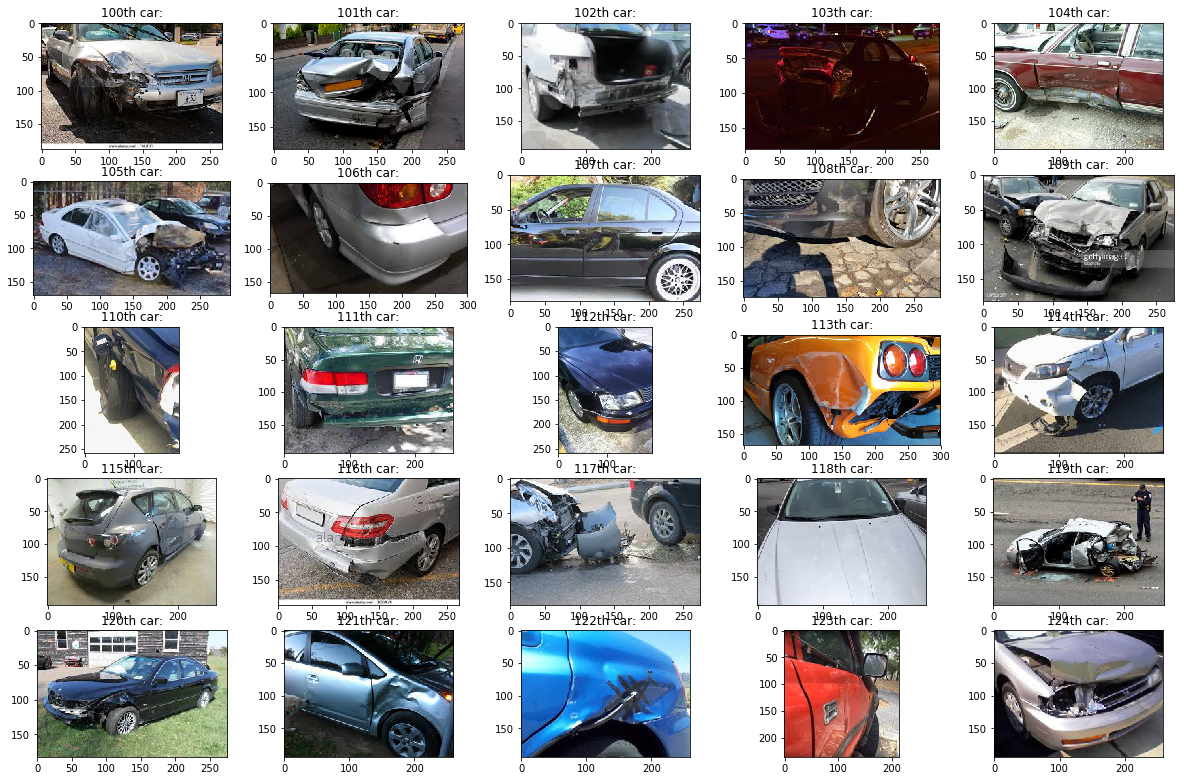

In [0]:
#this cells allows to visualies the cars in the order they are in our training or validation list, 
#One just needs to give in which list of picture one wants by defining picture_list to be the list of picture one
#wants to see
# by displaying matrix of pictures with the number in the list.so as to help create quickly hand-anotations
# much quicker than to display
#you have to define which list of pictures you want to see by putting picture_list equal to the list of adresses of pictures you want to see
picture_list=list_validation_damage_correct
fig, axs = plt.subplots(nrows=5, ncols=5)
fig.set_size_inches(20.5, 13.5)
axs = axs.flatten()
# Next we define the batch number j. we work with batches of 25 not randomly selected by from our list in
#the order in which they appear in list
j=4




for i in range(25):
 axs[i].imshow(open_image(picture_list[25*j+i]).data.transpose(2,0).transpose(1,0))
 axs[i].set_title(str(25*j+i)+"th car:")

# CLASSIFICATION AS MINOR MODERATE OR SEVERE


In [0]:
#Next we are creating a databunch with the cars picture minor, moderate or severe damage
data=ImageDataBunch.from_folder("data3a",train="training",valid="validation",size=229,bs=20)

data.normalize(imagenet_stats)
learn=cnn_learner(data,models.resnet50,metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 83587455.52it/s]


In [0]:
data.show_batch(rows=5,figsize=(15,13))
print(data.classes)
len(data.classes)

In [0]:
#next we run the learner:
learn.fit_one_cycle(10)

In [0]:
learn.save("stage1_resnet50")
learn.load("stage1_resnet50")

In [0]:
learn.unfreeze()

In [0]:
#Next we are making lists with the pictures names and path in the validation directory
#and also list of pictures in training directory
#in order to be able to go through all the misclassified pictures
basepath="data3a/validation/01-minor"
list_validation_minor=[os.path.join(basepath,entry) for entry in os.listdir(basepath)]
basepath="data3a/validation/02-moderate"
list_validation_moderate=[os.path.join(basepath,entry) for entry in os.listdir(basepath)]
basepath="data3a/validation/03-severe"
list_validation_severe=[os.path.join(basepath,entry) for entry in os.listdir(basepath)]
basepath="data3a/training/01-minor"
list_training_minor=[os.path.join(basepath,entry) for entry in os.listdir(basepath)]
basepath="data3a/training/02-moderate"
list_training_moderate=[os.path.join(basepath,entry) for entry in os.listdir(basepath)]
basepath="data3a/training/03-severe"
list_training_severe=[os.path.join(basepath,entry) for entry in os.listdir(basepath)]

print(list_validation_minor[:5])

['data3a/validation/01-minor/0039.JPEG', 'data3a/validation/01-minor/0027.jpeg', 'data3a/validation/01-minor/0022.JPEG', 'data3a/validation/01-minor/0033.JPEG', 'data3a/validation/01-minor/0044.JPEG']


In [0]:
#Next we are going to make different lists of validation pictures for front,rear and side according to if they were classified correctly and those which were classified wrong
#
#FOR MINOR damage:
picture_list=list_validation_minor
list_pred_minor=[learn.predict(item=open_image(im_adress))[0] for im_adress in picture_list]
list_pred_minor=[str(item) for item in list_pred_minor]
#the percentage in validation set that are minors damages and correctly predicted
print("Correct percentage for minor damages:")
print(np.mean(np.array(list_pred_minor)=="01-minor"))
list_validation_minor_error=[a for (a,b) in list(zip(list_validation_minor,list_pred_minor)) if (b!="01-minor")]
list_validation_minor_correct=[a for (a,b) in list(zip(list_validation_minor,list_pred_minor)) if (b=="01-minor")]

#FOR MODERATE damage:
picture_list=list_validation_moderate
list_pred_moderate=[learn.predict(item=open_image(im_adress))[0] for im_adress in picture_list]
list_pred_moderate=[str(item) for item in list_pred_moderate]
#the percentage in validation set that are moderate damage and correctly predicted
print("Correct percentage for moderate damage:")
print(np.mean(np.array(list_pred_moderate)=="02-moderate"))
list_validation_moderate_error=[a for (a,b) in list(zip(list_validation_moderate,list_pred_moderate)) if (b!="02-moderate")]
list_validation_moderate_correct=[a for (a,b) in list(zip(list_validation_moderate,list_pred_moderate)) if (b=="02-moderate")]

#FOR SEVERE damage:
picture_list=list_validation_severe
list_pred_severe=[learn.predict(item=open_image(im_adress))[0] for im_adress in picture_list]
list_pred_severe=[str(item) for item in list_pred_severe]
#the percentage in validation set that are severe-damage and correctly predicted
print("Correct percentage for severe damage:")
print(np.mean(np.array(list_pred_severe)=="03-severe"))
list_validation_severe_error=[a for (a,b) in list(zip(list_validation_severe,list_pred_severe)) if (b!="03-severe")]
list_validation_severe_correct=[a for (a,b) in list(zip(list_validation_severe,list_pred_severe)) if (b=="03-severe")]


Correct percentage for minor damages:
0.6458333333333334
Correct percentage for moderate damage:
0.43636363636363634
Correct percentage for severe damage:
0.8088235294117647


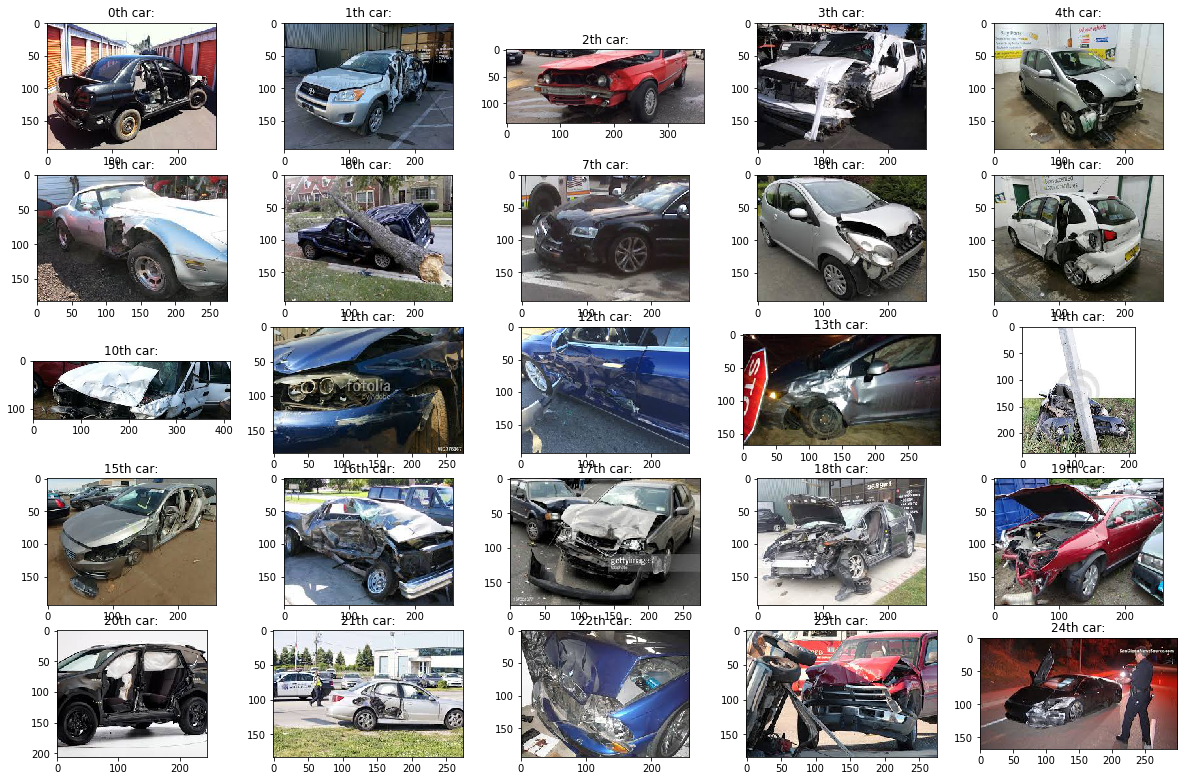

In [0]:
#this cells allows to visualies the cars in the order they are in our training or validation list, 
#One just needs to give in which list of picture one wants by defining picture_list to be the list of picture one
#wants to see
# by displaying matrix of pictures with the number in the list.so as to help create quickly hand-anotations
# much quicker than to display
#you have to define which list of pictures you want to see by putting picture_list equal to the list of adresses of pictures you want to see
picture_list=list_validation_severe_correct
fig, axs = plt.subplots(nrows=5, ncols=5)
fig.set_size_inches(20.5, 13.5)
axs = axs.flatten()
# Next we define the batch number j. we work with batches of 25 not randomly selected by from our list in
#the order in which they appear in list
j=0



for i in range(25):
 axs[i].imshow(open_image(picture_list[25*j+i]).data.transpose(2,0).transpose(1,0))
 axs[i].set_title(str(25*j+i)+"th car:")

In [0]:
#next we run the learner:
learn.fit_one_cycle(10)

In [0]:
#learn.save("stage1_resnet50")
learn.load("stage1_resnet50")

In [0]:
learn.unfreeze()

In [0]:
#Next we are making lists with the pictures names and path in the validation directory
#and also list of pictures in training directory
#in order to be able to go through all the misclassified pictures
basepath="data2a/validation/00-front"
list_validation_front=[os.path.join(basepath,entry) for entry in os.listdir(basepath)]
basepath="data2a/validation/01-rear"
list_validation_rear=[os.path.join(basepath,entry) for entry in os.listdir(basepath)]
basepath="data2a/validation/02-side"
list_validation_side=[os.path.join(basepath,entry) for entry in os.listdir(basepath)]
basepath="data2a/training/00-front"
list_training_front=[os.path.join(basepath,entry) for entry in os.listdir(basepath)]
basepath="data2a/training/01-rear"
list_training_rear=[os.path.join(basepath,entry) for entry in os.listdir(basepath)]
basepath="data2a/training/02-side"
list_training_side=[os.path.join(basepath,entry) for entry in os.listdir(basepath)]

print(list_validation_front[:5])

['data2a/validation/00-front/0072.JPEG', 'data2a/validation/00-front/0013.JPEG', 'data2a/validation/00-front/0024.JPEG', 'data2a/validation/00-front/0035.JPEG', 'data2a/validation/00-front/0046.JPEG']


In [0]:
#Next we are going to make different lists of validation pictures for front,rear and side according to if they were classified correctly and those which were classified wrong
#
#FOR SIDE:
picture_list=list_validation_side
list_pred_side=[learn.predict(item=open_image(im_adress))[0] for im_adress in picture_list]
list_pred_side=[str(item) for item in list_pred_side]
#the percentage in validation set that are front and correctly predicted
print("Correct percentage for side:")
print(np.mean(np.array(list_pred_side)=="02-side"))
list_validation_side_error=[a for (a,b) in list(zip(list_validation_side,list_pred_side)) if (b!="02-side")]
list_validation_side_correct=[a for (a,b) in list(zip(list_validation_side,list_pred_side)) if (b=="02-side")]

#FOR FRONT:
picture_list=list_validation_front
list_pred_front=[learn.predict(item=open_image(im_adress))[0] for im_adress in picture_list]
list_pred_front=[str(item) for item in list_pred_front]
#the percentage in validation set that are front and correctly predicted
print("Correct percentage for front:")
print(np.mean(np.array(list_pred_front)=="00-front"))
list_validation_front_error=[a for (a,b) in list(zip(list_validation_front,list_pred_front)) if (b!="00-front")]
list_validation_front_correct=[a for (a,b) in list(zip(list_validation_front,list_pred_front)) if (b=="00-front")]

#FOR REAR:
picture_list=list_validation_rear
list_pred_rear=[learn.predict(item=open_image(im_adress))[0] for im_adress in picture_list]
list_pred_rear=[str(item) for item in list_pred_rear]
#the percentage in validation set that are front and correctly predicted
print("Correct percentage for rear:")
print(np.mean(np.array(list_pred_rear)=="01-rear"))
list_validation_rear_error=[a for (a,b) in list(zip(list_validation_rear,list_pred_rear)) if (b!="01-rear")]
list_validation_rear_correct=[a for (a,b) in list(zip(list_validation_rear,list_pred_rear)) if (b=="01-rear")]


Correct percentage for side:
0.7291666666666666
Correct percentage for front:
0.9041095890410958
Correct percentage for rear:
0.78


IndexError: ignored

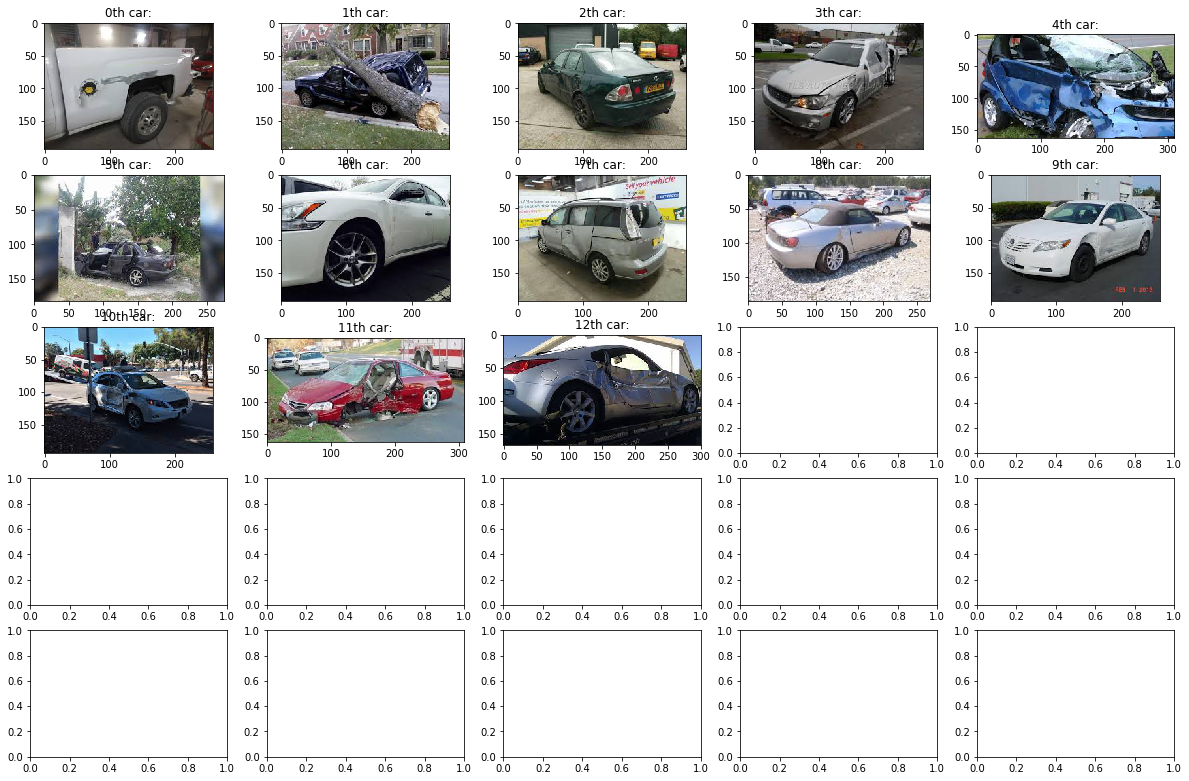

In [0]:
#this cells allows to visualies the cars in the order they are in our training or validation list, 
#One just needs to give in which list of picture one wants by defining picture_list to be the list of picture one
#wants to see
# by displaying matrix of pictures with the number in the list.so as to help create quickly hand-anotations
# much quicker than to display
#you have to define which list of pictures you want to see by putting picture_list equal to the list of adresses of pictures you want to see
picture_list=list_validation_side_error
fig, axs = plt.subplots(nrows=5, ncols=5)
fig.set_size_inches(20.5, 13.5)
axs = axs.flatten()
# Next we define the batch number j. we work with batches of 25 not randomly selected by from our list in
#the order in which they appear in list
j=0



for i in range(25):
 axs[i].imshow(open_image(picture_list[25*j+i]).data.transpose(2,0).transpose(1,0))
 axs[i].set_title(str(25*j+i)+"th car:")

In [0]:
interp=ClassificationInterpretation.from_learner(learn)

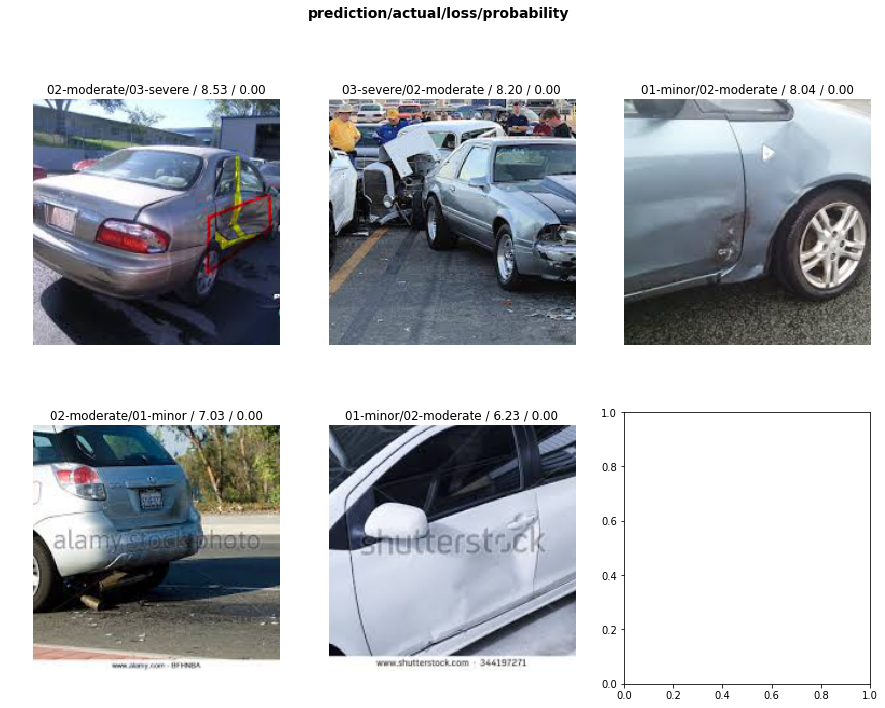

In [0]:
interp.plot_top_losses(5,heatmap=False,figsize=(15,11))